# SNGP ESC50
Train and evaluate a resnet-50 on esc50 using SNGP.

In [1]:
import os
import tempfile

import torch
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models.fc_resnet import FCResNet
from lightning_uq_box.uq_methods import SNGPClassification
from lightning_uq_box.viz_utils import (
    plot_predictions_classification,
    plot_training_metrics,
    plot_two_moons_data,
)

# Configure tmp dir for logs and checkpoints
tmp_dir = '/workspace/logs/tmp'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed_everything(2)

Seed set to 2


2

# Datamodule

In [3]:
from birdset.datamodule.base_datamodule import DatasetConfig
from birdset.datamodule.components.resize import Resizer
from birdset.datamodule.esc50_datamodule import ESC50DataModule
from birdset.datamodule.components.transforms import BirdSetTransformsWrapper, PreprocessingConfig

preprocessing = PreprocessingConfig(
    resizer=Resizer(
        db_scale=True,
        target_height=128,
        target_width=128,
    ),
)
transforms = BirdSetTransformsWrapper(preprocessing=preprocessing, task='multiclass')

dm = ESC50DataModule(transforms=transforms)

In [7]:
dm.prepare_data()
# setup the dataloaders
dm.setup(stage="fit")
# get the dataloaders
train_loader = dm.train_dataloader()
# get the first batch
batch = next(iter(train_loader))
# get shape of the batch
print(batch["input_values"].shape)
print(batch["labels"].shape)

In [5]:
# get type of the labels tensor
print(batch["labels"].dtype)

torch.float16


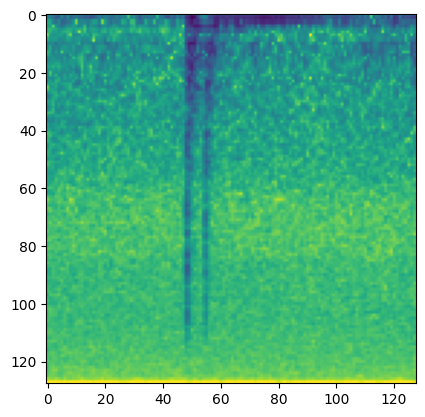

In [5]:
# plot first image
from matplotlib import pyplot as plt


plt.imshow(batch["input_values"][0].permute(1, 2, 0))


# Model

In [6]:
from birdset.modules.models.resnet import ResNetClassifier
resnet = ResNetClassifier(
    baseline_architecture = 'resnet50',
    num_classes = dm.num_classes,
    pretrained = False,
)


In [7]:
sngp = SNGPClassification(
    feature_extractor=resnet,
    loss_fn=torch.nn.CrossEntropyLoss(),
    num_targets=dm.num_classes,
    input_size=128
)

In [8]:
sngp.target_key = "labels"
sngp.input_key = "input_values"

# Trainer

In [11]:
logger = CSVLogger(tmp_dir)
trainer = Trainer(
    max_epochs=10,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=tmp_dir,
    devices=[2]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(sngp, dm)


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                  | Params
------------------------------------------------------------
0 | feature_extractor | ResNetClassifier      | 23.6 M
1 | loss_fn           | CrossEntropyLoss      | 0     
2 | normalize         | LayerNorm             | 256   
3 | rff               | RandomFourierFeatures | 0     
4 | beta              | Linear                | 51.2 K
5 | train_metrics     | MetricCollection      | 0     
6 | val_metrics       | MetricCollection      | 0     
7 | test_metrics      | MetricCollection      | 0     
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Half'

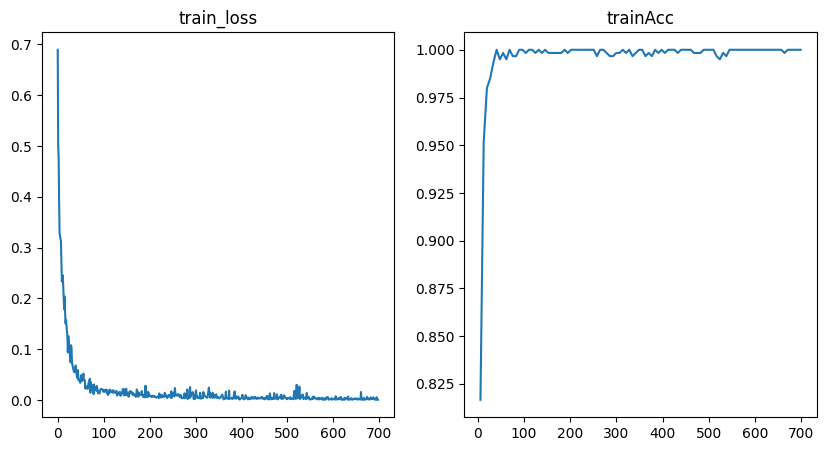

In [13]:
fig = plot_training_metrics(
    os.path.join(tmp_dir, "lightning_logs"), ["train_loss", "trainAcc"]
)

# Predictions

In [14]:
preds = sngp.predict_step(test_grid_points)


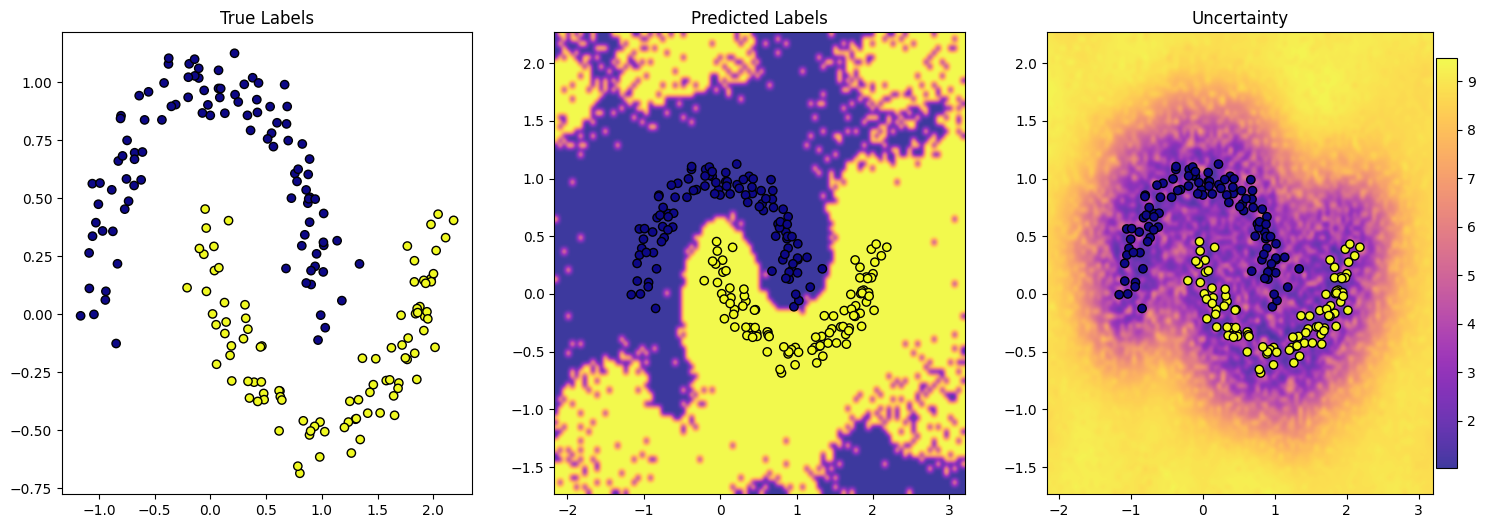

In [15]:
fig = plot_predictions_classification(
    X_test,
    y_test,
    preds["pred"].argmax(-1),
    test_grid_points,
    preds["pred_uct"].cpu().numpy(),
)